# Data Cleaning

## Objectives

* Evaluate the missing data
* Clean the data
  
## Inputs

* Dataset: `outputs/datasets/collection/house_prices_records.csv`

## Outputs

* Generate a fully cleaned set for study, and cleaned Train and Test set.
  * `outputs/datasets/cleaned/CompleteSetCleaned.csv`
  * `outputs/datasets/cleaned/TrainSetCleaned.csv`
  * `outputs/datasets/cleaned/TestSetCleaned.csv`

## Conclusions

* Perform the following Imputations
  * Drop Features - `EnclosedPorch`, `WoodDeckSF`
  * Median Imputation - `LotFrontage`, `GarageYrBlt`
  * Mean Imputation - `BedroomAbvGr`
  * Arbitrary Imputation (Zero) - `2ndFlrSF`, `MasVnrArea`
  * Categorical Imputation (Mode) - `GarageFinish`, `BsmtFinType1`

---

# Import all modules required in the workbook

In [1]:
import os
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer

sns.set_style("whitegrid")


# Change working directory

The notebooks for this project are stored in a subfolder called `jupyter_notebooks`, therefore when running the notebook, the working directory needs to be changed to the parent folder. 
* We access the current directory with `os.getcwd()`

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/pp5-house-price-predictor/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory of: ", os.getcwd())

You set a new current directory of:  /workspace/pp5-house-price-predictor


---

# Load Collected Data

In [4]:
df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Data Exploration

We will check the distribution and shape of the variables with missing data. Also added a comparison of variables without missing data to review differences in data types. 

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
vars_without_missing_data = df.columns[df.isna().sum() == 0].to_list()
vars_without_missing_data

['1stFlrSF',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'GarageArea',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
 'SalePrice']

In [7]:
df[vars_with_missing_data].isna().sum()

2ndFlrSF           86
BedroomAbvGr       99
BsmtFinType1      114
EnclosedPorch    1324
GarageFinish      162
GarageYrBlt        81
LotFrontage       259
MasVnrArea          8
WoodDeckSF       1305
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       1460 non-null   int64  
 1   2ndFlrSF       1374 non-null   float64
 2   BedroomAbvGr   1361 non-null   float64
 3   BsmtExposure   1460 non-null   object 
 4   BsmtFinSF1     1460 non-null   int64  
 5   BsmtFinType1   1346 non-null   object 
 6   BsmtUnfSF      1460 non-null   int64  
 7   EnclosedPorch  136 non-null    float64
 8   GarageArea     1460 non-null   int64  
 9   GarageFinish   1298 non-null   object 
 10  GarageYrBlt    1379 non-null   float64
 11  GrLivArea      1460 non-null   int64  
 12  KitchenQual    1460 non-null   object 
 13  LotArea        1460 non-null   int64  
 14  LotFrontage    1201 non-null   float64
 15  MasVnrArea     1452 non-null   float64
 16  OpenPorchSF    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  OverallQ

In [9]:
df[vars_with_missing_data].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1374 non-null   float64
 1   BedroomAbvGr   1361 non-null   float64
 2   BsmtFinType1   1346 non-null   object 
 3   EnclosedPorch  136 non-null    float64
 4   GarageFinish   1298 non-null   object 
 5   GarageYrBlt    1379 non-null   float64
 6   LotFrontage    1201 non-null   float64
 7   MasVnrArea     1452 non-null   float64
 8   WoodDeckSF     155 non-null    float64
dtypes: float64(7), object(2)
memory usage: 102.8+ KB


In [10]:
df[vars_without_missing_data].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   1stFlrSF      1460 non-null   int64 
 1   BsmtExposure  1460 non-null   object
 2   BsmtFinSF1    1460 non-null   int64 
 3   BsmtUnfSF     1460 non-null   int64 
 4   GarageArea    1460 non-null   int64 
 5   GrLivArea     1460 non-null   int64 
 6   KitchenQual   1460 non-null   object
 7   LotArea       1460 non-null   int64 
 8   OpenPorchSF   1460 non-null   int64 
 9   OverallCond   1460 non-null   int64 
 10  OverallQual   1460 non-null   int64 
 11  TotalBsmtSF   1460 non-null   int64 
 12  YearBuilt     1460 non-null   int64 
 13  YearRemodAdd  1460 non-null   int64 
 14  SalePrice     1460 non-null   int64 
dtypes: int64(13), object(2)
memory usage: 171.2+ KB


* Noticed that the data types with missing data are either float or object, and the data types without missing data are int or object. This is potentially due to the nature in which NaN is recorded as a float64 type. We can review these inconsistencies at the end of the data cleaning process, as you can assume all values of square feet are recorded as whole integers and not as decimal numbers. This can address the performance and consistency point referred to at the end of `1_Data_Collection.ipynb`

In [11]:
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Initial Review**
* 2ndFlrSF missing 5.9% of values, numeric, 53.5% zero's, min=0 : max=2065
* BedroomAbvGr missing 6.8% of values, numeric, 0.4% zero's, min=0 : max=8 (why are there zeros for bedrooms?)
* BsmtFinType1 missing 7.8% of values, categorical (7 categories), none=31 instances : unf=396 instances
* EnclosedPorch missing 90.7% of values, numeric, 7.9% zero's, min=0 : max=286, (consider dropping?)
* GarageFinish missing 11.1% of values, categorical (4 categories), none=73 (5.6%) instances : unf=546 (42.1%) instances
* GarageYrBlt missing 5.5% of values, numeric, 0.0% zero's, min=1900 : max=2010
* LotFrontage missing 17.7% of values, numeric, 0.0% zero's, min=21 : max=313
* MasVnrArea missing 0.5% of values, numeric, 59.0% zero's, min=0 : max=1600
* WoodDeckSF missing 89.4% of values, numeric, 5.3% zero's, min=0 : max=736 (consider dropping?)

# Correlation and PPS Analysis

* We run a correlation and PPS Analysis to help guide the data cleaning steps further in the workflow. Allowing us to determine the impact missing data affects the relationships between variables, and to help direct which variables need closer attention when performing imputation in the data cleaning process. 

In [12]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print("PPS detects linear or non-linear relationships between two columns.\n"
          "The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

In [13]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


* As this review is conducted on unclean data, it was expected that there would be some warnings which have indicated there are potentially some imbalance in the data. This will be picked up during the comprehesive cleaning process and re-assessed. 



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



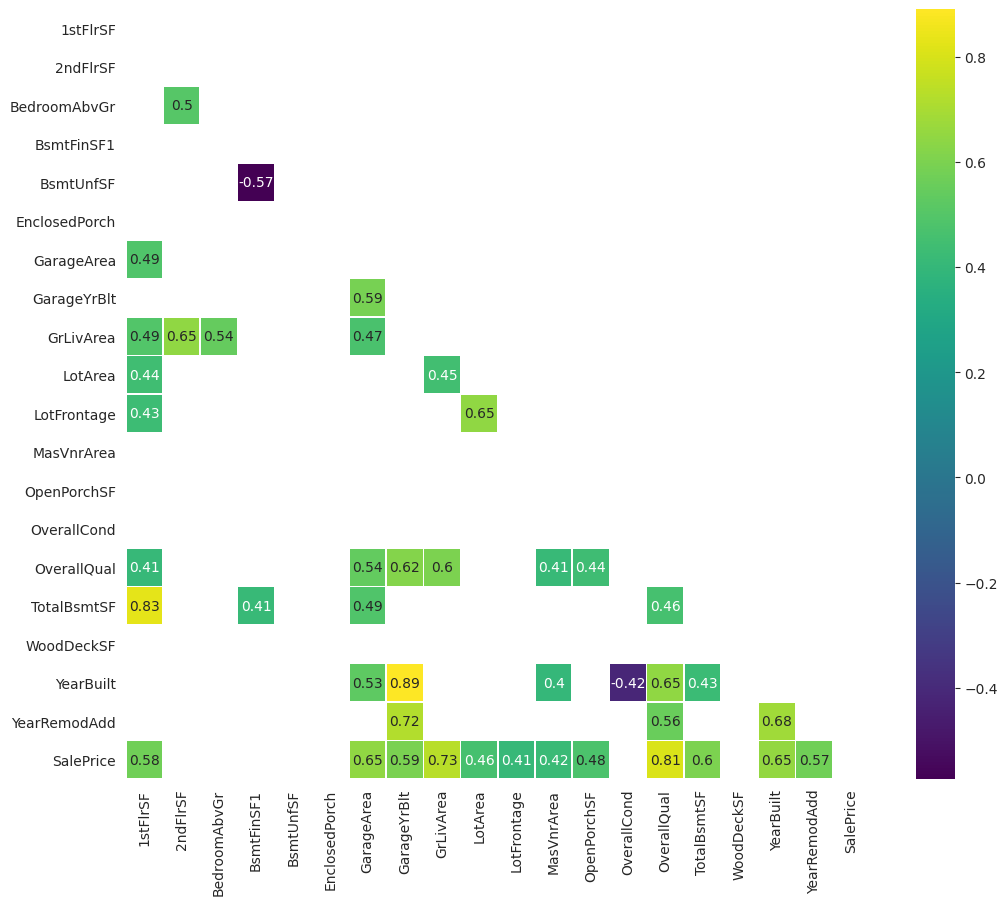



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



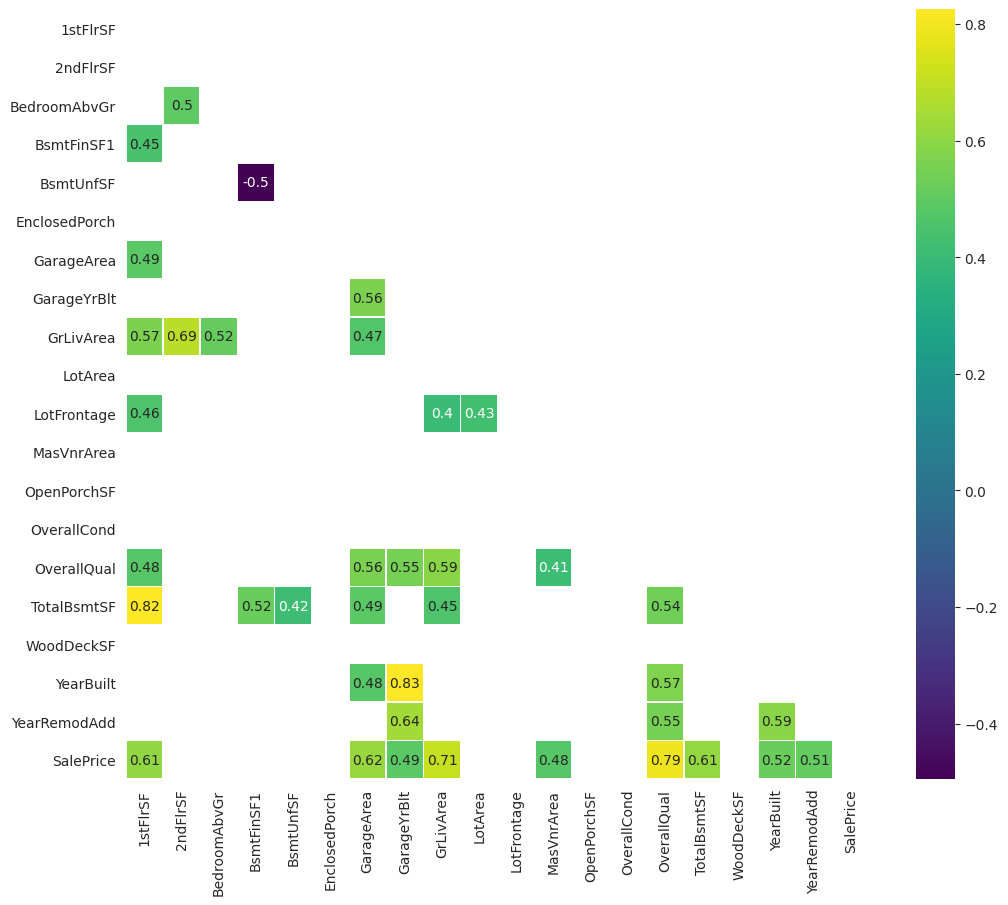



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



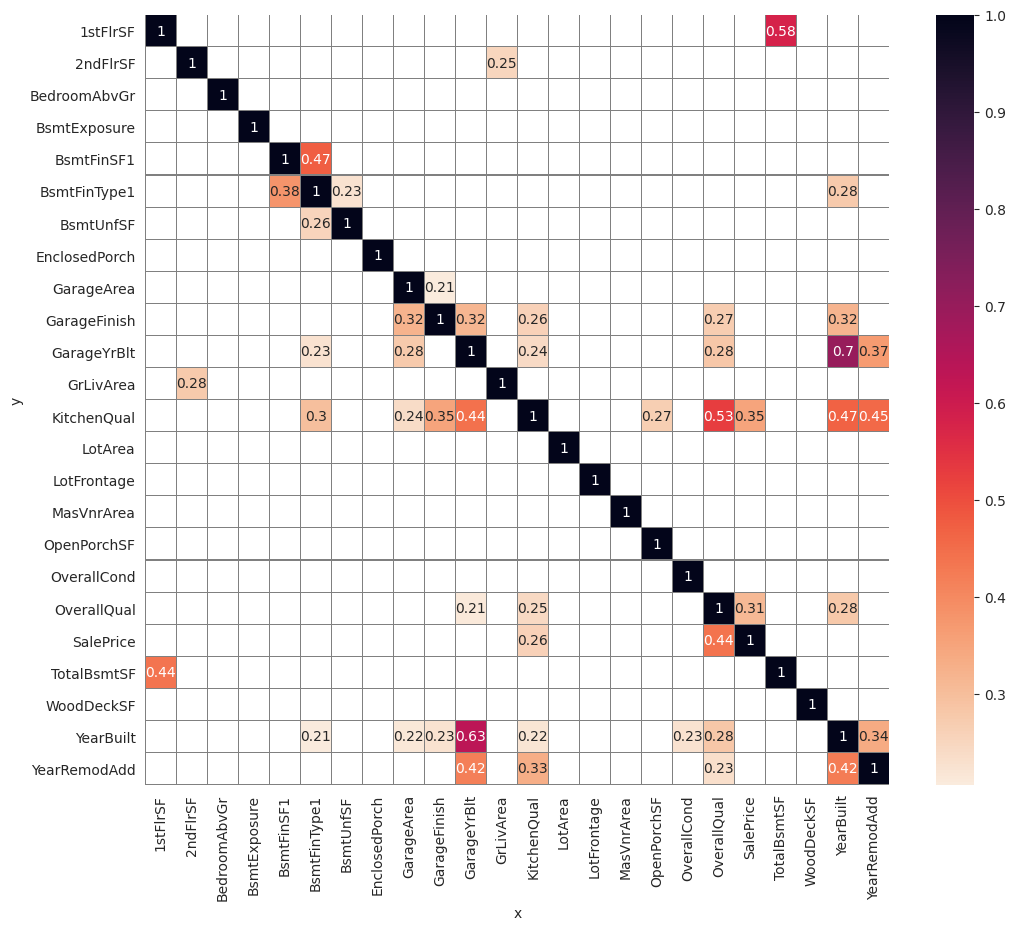

In [14]:
DisplayCorrAndPPS(df_corr_pearson=df_corr_pearson,
                  df_corr_spearman=df_corr_spearman,
                  pps_matrix=pps_matrix,
                  CorrThreshold=0.4,
                  PPS_Threshold=0.2,
                  figsize=(12, 10),
                  font_annot=10)


**Initial Findings**

* Spearman correlation:
  * Very Strong Correlation (0.7 - 1.0)
    * Features vs SalePrice
      * highlights that there is very strong correlation between `OverallQual` and `GrLivArea` vs `SalePrice`
    * Multi-colinearity
      * highlights that there is very strong multi-colinearity between `YearBuilt` and `GarageYrBlt`
  * highlights that there is very strong multi-colinearity between `TotalBsmtSF` and `1stFlrSF`
  * Strong Correlation (0.5 - 0.7) - *summarised for anything > 0.6
    * Features vs SalePrice
      * highlights that there is strong correlation between `1stFlrSF`, `GarageArea`, `GarageYrBlt`, `TotalBsmtSF`, `YearBuilt` and `YearRemodAdd`
    * Multi-colinearity
      * highlights that there is strong multi-colinearity between `GrLivArea` and `2ndFlrSF`
      * highlights that there is strong multi-colinearity between `OverallQual` and `GarageYrBlt`
      * highlights that there is strong multi-colinearity between `OverallQual` and `GrLivArea`
      * highlights that there is strong multi-colinearity between `OverallQual` and `YearBuilt`
      * highlights that there is strong multi-colinearity between `YearBuilt` and `YearRemodAdd`
* Pearson correlation:
  * Very Strong Correlation (0.7 - 1.0)
    * Features vs SalePrice
      * highlights that there is very strong correlation between `OverallQual` and `GrLivArea` vs `SalePrice`
    * Multi-colinearity
      * highlights that there is very strong multi-colinearity between `YearBuilt` and `GarageYrBlt`
      * highlights that there is very strong multi-colinearity between `TotalBsmtSF` and `1stFlrSF`
  * Strong Correlation (0.5 - 0.7) - *summarised for anything > 0.6
    * Features vs SalePrice
      * highlights that there is strong correlation between `1stFlrSF`, `GarageArea`, `GarageYrBlt`, `TotalBsmtSF`, `YearBuilt` and `YearRemodAdd`
    * Multi-colinearity
      * highlights that there is strong multi-colinearity between `GrLivArea` and `2ndFlrSF`
* Power Predictive Score
  * `GarageYrBlt` indicates it is a strong predictor of `YearBuilt` with a PPS of 0.70
  * `YearBuilt` indicates it is a moderate predictor of `GarageYrBlt` with with a PPS of 0.63
  * `OverallQual` indicates it is a moderate predictor of `KitchenQual` of with a PPS of 0.53

# Data Cleaning

### Assessing Missing Data Levels

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [15]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(data={
                                        "RowsWithMissingData": missing_data_absolute,
                                        "PercentageOfDataset": missing_data_percentage,
                                        "DataType": df.dtypes}
                                    ).sort_values(by=['PercentageOfDataset'], ascending=False)
                                     .query("PercentageOfDataset > 0")
                       )

    return df_missing_data


Check missing data levels for the collected dataset.

In [16]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


There are two variables in consideration for dropping, due to high levels of missing data. Those being `EnclosedPorch` & `WoodDeckSF`. They are unlikely to give any reliable information by trying to impute the missing values. 


## Dealing with Missing Data

* Load in a function to help with asssessing the Data Cleaning process. The function was provided by code institute as part of the Predictive Analysis Course. 
* The overall objective of the function is to assess the effect of the cleaning process for different types of imputations. Mean, Median and Arbitrary Imputations on Numerical values, and when replacing Categorical variables with "Missing" or a most frequent category. 

In [17]:
def DataCleaningEffect(df_original, df_cleaned, variables_applied_with_method):

    # Indicate plot number
    flag_count = 1

    # distinguish between numerical and categorical variables
    categorical_variables = df_original.select_dtypes(exclude=['number']).columns

    # scan over variables,
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
    for set_of_variables in [variables_applied_with_method]:
        print("\n=====================================================================================")
        print("* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
        print(f"{set_of_variables} \n\n")

        for var in set_of_variables:
            if var in categorical_variables:

                df1 = pd.DataFrame({"Type": "Original", "Value": df_original[var]})
                df2 = pd.DataFrame({"Type": "Cleaned", "Value": df_cleaned[var]})
                dfAux = pd.concat([df1, df2], axis=0)
                fig, axes = plt.subplots(figsize=(15, 5))
                sns.countplot(hue='Type', data=dfAux, x="Value", palette=['#432371', "#FAAE7B"])
                axes.set(title=f"Distribution Plot {flag_count}: {var}")
                plt.xticks(rotation=90)
                plt.legend()

            else:

                fig, axes = plt.subplots(figsize=(10, 5))
                sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True, element="step", ax=axes)
                sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True, element="step", ax=axes)
                axes.set(title=f"Distribution Plot {flag_count}: {var}")
                plt.legend()

            plt.show()
            flag_count += 1

### Data Cleaning Summary

#### EnclosedPorch - Drop Missing Data

* For the EnclosedPorch, I will drop this variable due to the high quantity of missing data (89.38%), and with it being unlikely to impute any reliable information from it. 

#### WoodDeckSF - Drop Missing Data

* For the EnclosedPorch, I will drop this variable due to the high quantity of missing data (89.38%), and with it being unlikely to impute any reliable information from it.

#### LotFrontage - Median Imputation

* For the LotFrontage, I will Impute using Median as even though the data has close Mean (69) and Median (70.04995837) values, it has a high positive Skewness (2.163569142) indicating a long right tail and also has high positive Kurtosis (17.45286726) which implies there is a presence of outliers. Therefore Median would be the best approach as its less affected by extreme values compared to the mean. 

#### BedroomAbvGr - Mean Imputation

* For the BedroomAbvGr, I will Impute using Mean due to the Mean and Median being close indicates a normal distribution. This is supported by the Skewness (0.23) being close to zero, indicating the feature is not skewed and close to normal. Mean imputation is also supported by Kurtosis (2.32), which implies the tails are shorter and not many outliers. 

#### 2ndFlrSF - Arbitrary Number Imputation (using Zero)

* For the 2ndFlrSF, as there are no other features to assist in the imputation of this, as ideally a feature that described the number of floors would be helpful. I have decided to use an arbitrary imputation of zero due to the already existing large proportion of the values being zero. Implying houses do not have a second floor. There is correlation for both Spearman (0.65) and Pearson (0.69) between the GrLivArea and 2ndFlrSF, but this cannot be used effectively to impute due to so many zero values in the data.  The only other approach that would seem feasible is to obtain additional information on the houses for the amount of floors, but as the data set does not contain this information, I am considering that approach out of scope for now. 

#### GarageYrBlt	- Median Imputation

* For the GarageYrBlt, I will impute using Median due to Mean (1978.5) and Median (1980) being close indicates a fairly normal distribution, but as the data shows slight skewness (-0.65) and light tails from the kurtosis calculation (-0.42), median imputation seems best. I could also explore more advanced imputation if the model does not perform by using the correlated variable YearBuilt. 

#### MasVnrArea	- Arbitrary Number Imputation (using Zero)

* For the MasVnrArea, I have decided to use an arbitrary imputation of zero due to the already existing large proportion of the values being zero (59%). Also due to the skewness (2.67) indicating most of the values are close to zero and kurtosis (10.08) indicating lots of outliers. 

#### GarageFinish - Categorical Imputation (Mode)

* For the GarageFinish, as I did not perform any initial encoding during the first iteration of correlation and PPS analysis I will simply impute this feature with the most frequent value. I will revisit this method if the model is not performing and there is any correlation within the data to suggest a more indepth method might give better results (like using "missing" or using correlated variables). 


#### BsmtFinType1 - Categorical Imputation (Mode)

* For the BsmtFinType1, as I did not perform any initial encoding during the first iteration of correlation and PPS analysis I will simply impute this feature with the most frequent value. I will revisit this method if the model is not performing and there is any correlation within the data to suggest a more indepth method might give better results (like using "missing" or using correlated variables). 


### Split Train and Test Set

In [18]:
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


Evaluate the missing data differences between train, test and full data, by merging the data sets and calculating the percentage point difference between Train and Full sets, and Test and Full sets. 

In [19]:
full_missing_data = EvaluateMissingData(df)
train_missing_data = EvaluateMissingData(TrainSet)
test_missing_data = EvaluateMissingData(TestSet)

missing_data_comparison = pd.merge(test_missing_data,
                                   train_missing_data,
                                   left_index=True,
                                   right_index=True,
                                   suffixes=('_Test', '_Train')
                                   )

missing_data_comparison = pd.merge(missing_data_comparison,
                                   full_missing_data,
                                   left_index=True,
                                   right_index=True
                                   )

missing_data_comparison_pct = missing_data_comparison.drop(columns=['DataType', 'DataType_Train', 'DataType_Test',
                                                                    'RowsWithMissingData', 'RowsWithMissingData_Train',
                                                                    'RowsWithMissingData_Test'])

# Calculate percentage point differences
missing_data_comparison_pct['PctPointDiff_Test_Full'] = (
    missing_data_comparison_pct['PercentageOfDataset_Test'] -
    missing_data_comparison_pct['PercentageOfDataset'])

missing_data_comparison_pct['PctPointDiff_Train_Full'] = (
    missing_data_comparison_pct['PercentageOfDataset_Train'] -
    missing_data_comparison_pct['PercentageOfDataset'])

missing_data_comparison_pct


,PercentageOfDataset_Test,PercentageOfDataset_Train,PercentageOfDataset,PctPointDiff_Test_Full,PctPointDiff_Train_Full
WoodDeckSF,92.81,88.53,89.38,3.43,-0.85
EnclosedPorch,91.78,90.41,90.68,1.10,-0.27
LotFrontage,16.10,18.15,17.74,-1.64,0.41
GarageFinish,10.62,11.22,11.10,-0.48,0.12
2ndFlrSF,8.90,5.14,5.89,3.01,-0.75
BsmtFinType1,8.56,7.62,7.81,0.75,-0.19
GarageYrBlt,7.88,4.97,5.55,2.33,-0.58
BedroomAbvGr,6.51,6.85,6.78,-0.27,0.07
MasVnrArea,0.68,0.51,0.55,0.13,-0.04


I am happy that the split represents each variable appropriately within the train and test sets vs the full set. `WoodDeckSF` is going to be dropped so not too concered with the 3.43 difference in the test set and it is expected that the percentage point differences in the Test set would be higher due to the smaller size in the data set. All Train set are +/- 1% which is acceptable. 

* Perform the following Imputations
  * Drop Features - `EnclosedPorch`, `WoodDeckSF`
  * Median Imputation - `LotFrontage`, `GarageYrBlt`
  * Mean Imputation - `BedroomAbvGr`
  * Arbitrary Imputation (Zero) - `2ndFlrSF`, `MasVnrArea`
  * Categorical Imputation (Mode) - `GarageFinish`, `BsmtFinType1`

### Drop Features

1. Select imputation approach
2. Select variables to apply the imputation approach

In [20]:
variables_method = ['EnclosedPorch', 'WoodDeckSF']

print(f"* {len(variables_method)} variables to drop \n\n"
      f"{variables_method}")

* 2 variables to drop 

['EnclosedPorch', 'WoodDeckSF']


3. Create a separate DataFrame applying this imputation approach to the selected variables.

In [21]:
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

4. Confirm variables have been dropped

In [22]:
print(TrainSet.columns.to_list())
print(df_method.columns.to_list())

['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice']
['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'GarageArea', 'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice']


### Median Imputation

1. Select imputation approach
2. Select variables to apply the imputation approach

In [23]:
variables_method = ['LotFrontage', 'GarageYrBlt']

print(f"* {len(variables_method)} variables to perform Median Imputation on \n\n"
      f"{variables_method}")

* 2 variables to perform Median Imputation on 

['LotFrontage', 'GarageYrBlt']


3. Create a separate DataFrame applying this imputation approach to the selected variables.

In [24]:
imputer = MeanMedianImputer(imputation_method='median',
                            variables=variables_method)
df_method = imputer.fit_transform(TrainSet)

4. Assess the effect on the variable's distribution.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'GarageYrBlt'] 




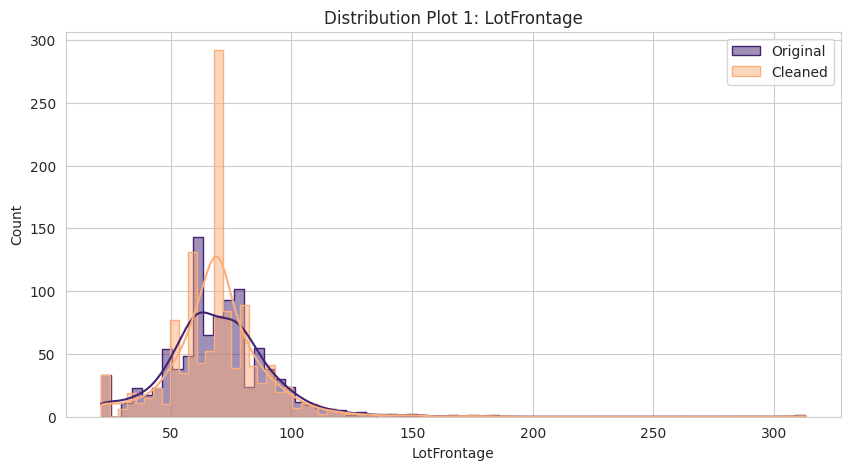

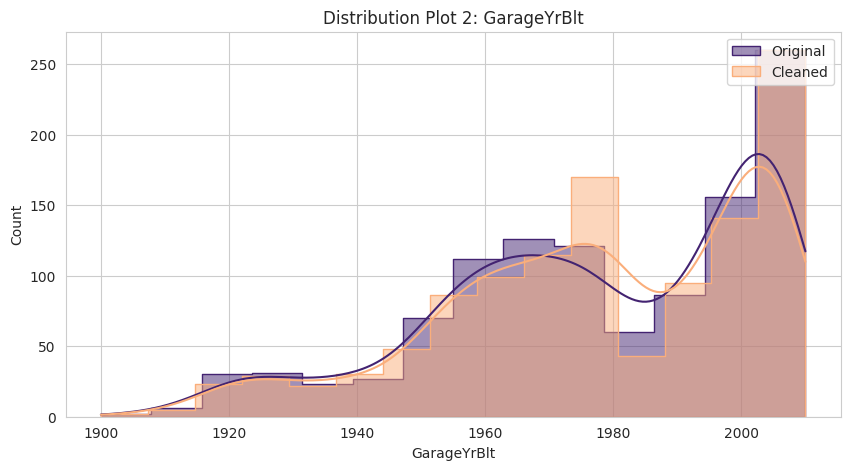

In [25]:
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

### Mean Imputation

1. Select imputation approach
2. Select variables to apply the imputation approach

In [26]:
variables_method = ['BedroomAbvGr']

print(f"* {len(variables_method)} variables to perform Mean Imputation on \n\n"
      f"{variables_method}")

* 1 variables to perform Mean Imputation on 

['BedroomAbvGr']


3. Create a separate DataFrame applying this imputation approach to the selected variables.

In [27]:
imputer = MeanMedianImputer(imputation_method='mean',
                            variables=variables_method)
df_method = imputer.fit_transform(TrainSet)

4. Assess the effect on the variable's distribution.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['BedroomAbvGr'] 




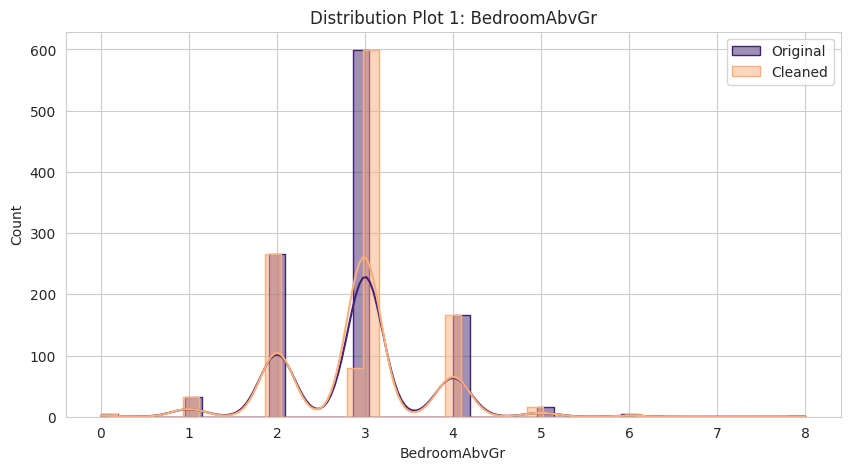

In [28]:
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

### Arbitrary Imputation (Zero)

1. Select imputation approach
2. Select variables to apply the imputation approach

In [29]:
variables_method = ['2ndFlrSF', 'MasVnrArea']

print(f"* {len(variables_method)} variables perform arbitrary imputation (zero) on \n\n"
      f"{variables_method}")

* 2 variables perform arbitrary imputation (zero) on 

['2ndFlrSF', 'MasVnrArea']


3. Create a separate DataFrame applying this imputation approach to the selected variables.

In [30]:
imputer = ArbitraryNumberImputer(arbitrary_number=0,
                                 variables=variables_method)
df_method = imputer.fit_transform(TrainSet)

4. Assess the effect on the variable's distribution.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'MasVnrArea'] 




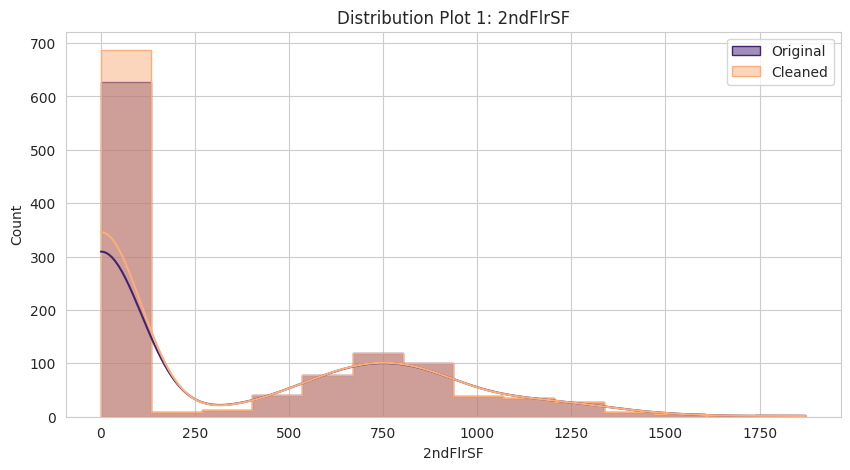

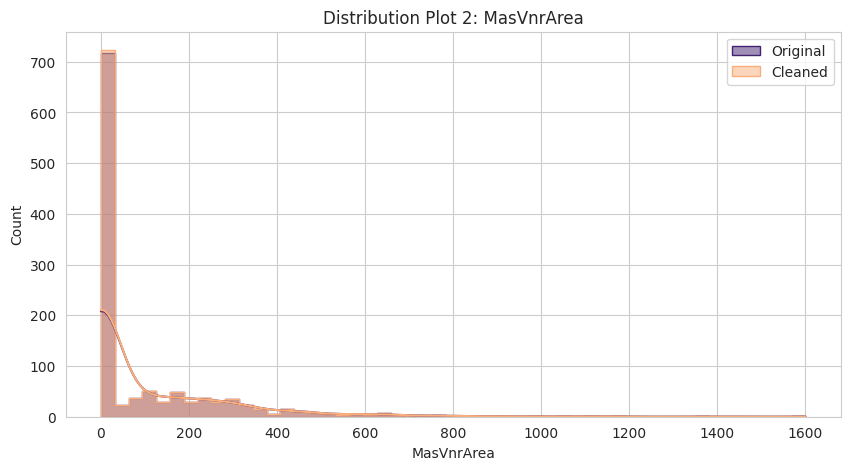

In [31]:
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

### Categorical Imputation (Mode)

1. Select imputation approach
2. Select variables to apply the imputation approach

In [32]:
variables_method = ['GarageFinish', 'BsmtFinType1']

print(f"* {len(variables_method)} variables to perform Categorical Imputation (Mode) on \n\n"
      f"{variables_method}")

* 2 variables to perform Categorical Imputation (Mode) on 

['GarageFinish', 'BsmtFinType1']


3. Create a separate DataFrame applying this imputation approach to the selected variables.

In [33]:
imputer = CategoricalImputer(imputation_method='frequent',
                             variables=variables_method)
df_method = imputer.fit_transform(TrainSet)

4. Assess the effect on the variable's distribution.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1'] 




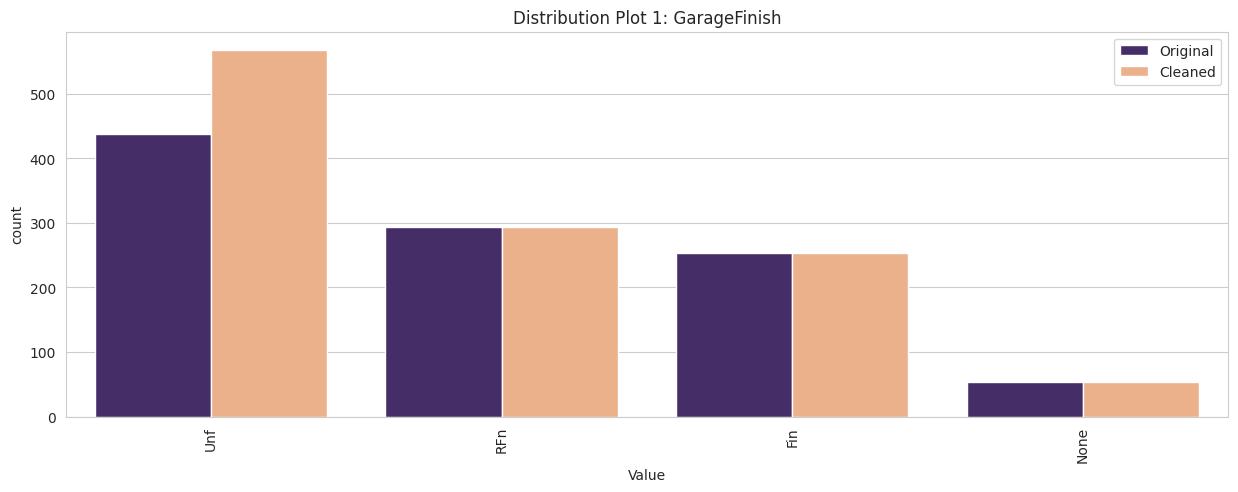

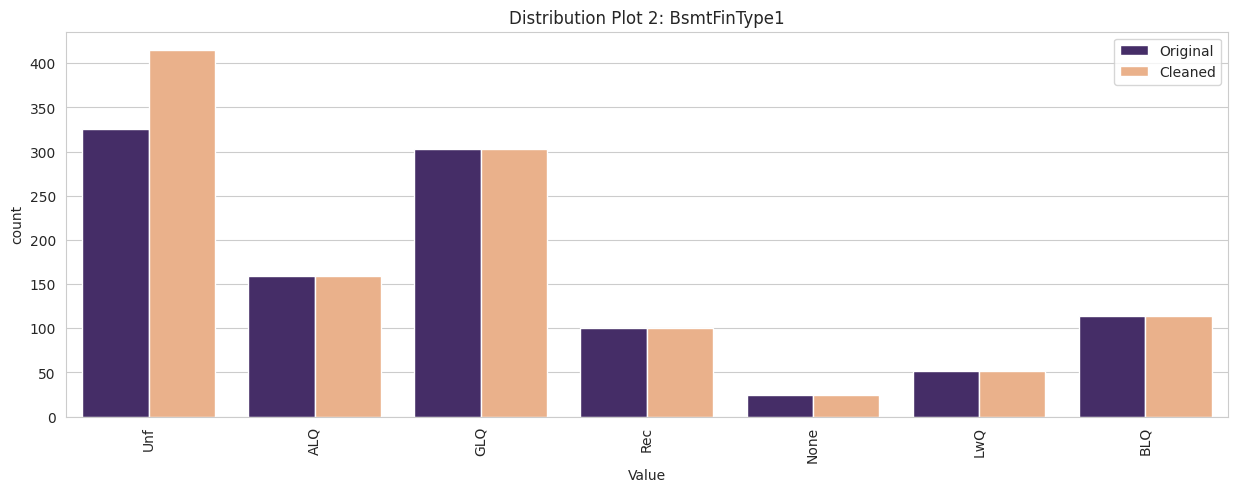

In [34]:
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

### Sklearn Data Cleaning Transformation Pipeline

In [35]:
cleaning_pipeline = Pipeline([
    ('median_imputer', MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'GarageYrBlt'])),
    ('mean_imputer', MeanMedianImputer(imputation_method='mean', variables=['BedroomAbvGr'])),
    ('zero_imputer', ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'MasVnrArea'])),
    ('mode_imputer', CategoricalImputer(imputation_method='frequent', variables=['GarageFinish', 'BsmtFinType1'])),
    ('drop_features', DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF']))
])

TrainSet, TestSet = cleaning_pipeline.fit_transform(TrainSet), cleaning_pipeline.fit_transform(TestSet)

In [36]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType


In [37]:
EvaluateMissingData(TestSet)

,RowsWithMissingData,PercentageOfDataset,DataType


### Create Complete Cleaned Dataset for Correlation Study

In [38]:
complete_cleaned_data = cleaning_pipeline.fit_transform(df)

### Push files to Repo

In [39]:
try:
    os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


### Train Set

In [40]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

### Test Set

In [41]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)

#### Complete Set

In [42]:
complete_cleaned_data.to_csv("outputs/datasets/cleaned/CompleteSetCleaned.csv", index=False)